# **Important Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# **Load Data**

In [2]:
df = pd.read_csv("/kaggle/input/california-housing-prices/housing.csv")
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


# **EDA**

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


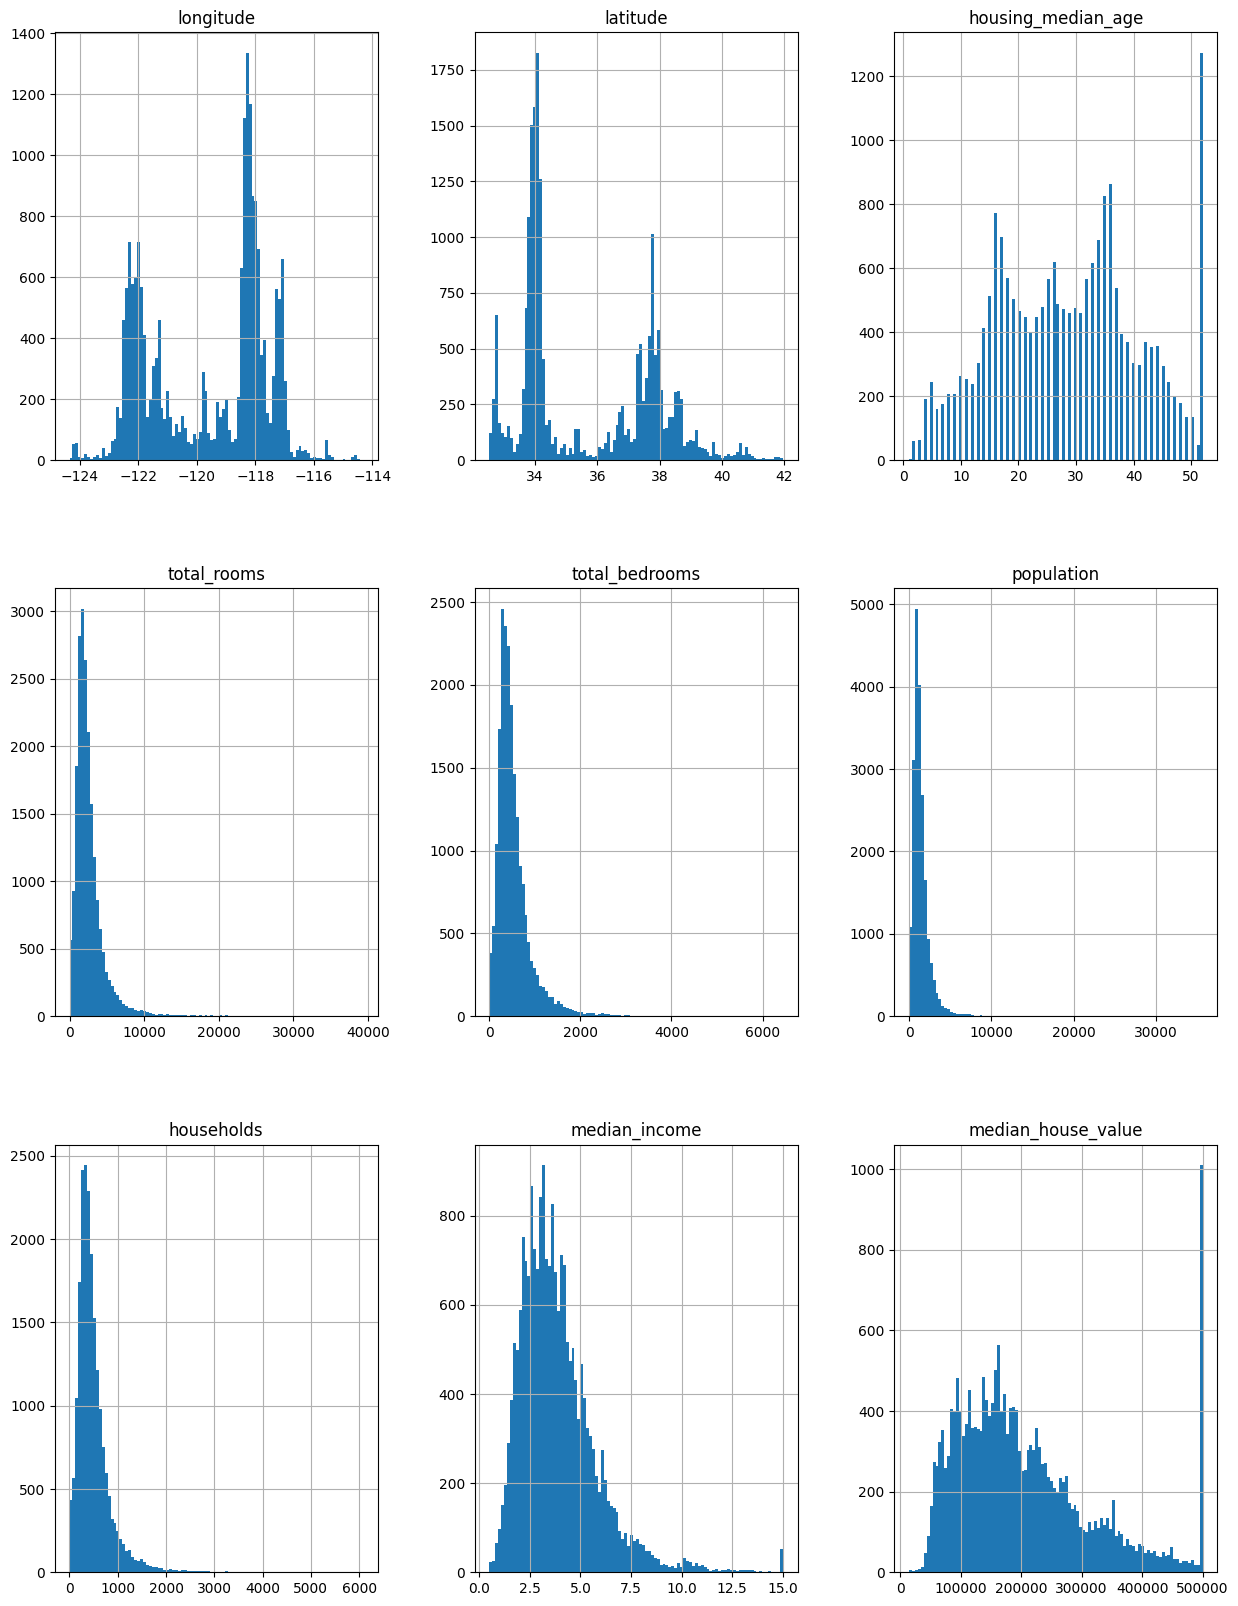

In [5]:
df.hist(bins=100,figsize=(15,20))
plt.show()

In [6]:
map_draw = folium.Map(location=[36.7783,-119.4179],
                    zoom_start = 6, min_zoom=5)

data = [[row['latitude'],row['longitude']] for index, row in df.iterrows()]
HeatMap(data, radius=10).add_to(map_draw)
map_draw

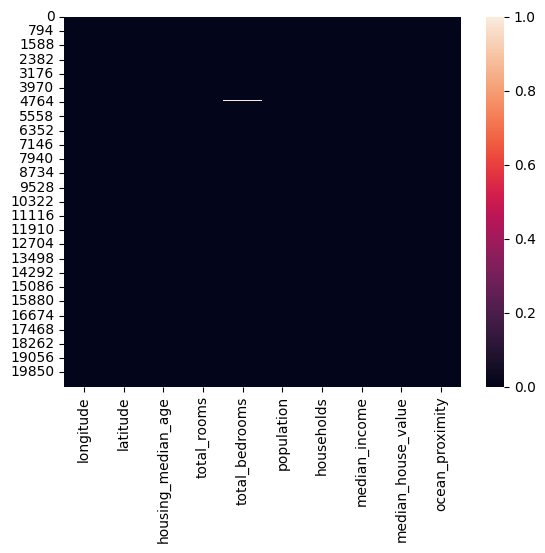

In [7]:
# Check for missing values
sns.heatmap(df.isnull())
plt.show()

In [8]:
# Check for missing values
df.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [9]:
# Convert numerical columns to float64, coercing errors to NaN
numerical_cols = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 
                  'total_bedrooms', 'population', 'households', 'median_income', 
                  'median_house_value']
for col in numerical_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [10]:
# Fill missing values in 'total_bedrooms' with computed median
total_bedrooms_median = df['total_bedrooms'].median()  # Compute median
df['total_bedrooms'] = df['total_bedrooms'].fillna(total_bedrooms_median)

In [11]:
# Drop rows with missing critical values
df = df.dropna(subset=['median_house_value', 'median_income', 'housing_median_age'])

In [12]:
# Add derived feature: rooms per household, handling division by zero
df['rooms_per_household'] = np.where(
    df['households'] != 0, 
    df['total_rooms'] / df['households'], 
    np.nan
)

In [13]:
# Drop rows where rooms_per_household is NaN or inf
df = df.dropna(subset=['rooms_per_household'])
df = df[np.isfinite(df['rooms_per_household'])]

In [14]:
# Verify data types and check for non-numeric values
print("\nData types after cleaning:\n", df.dtypes)
print("\nMissing values after cleaning:\n", df.isnull().sum())

# Check for non-numeric values in numerical columns
for col in numerical_cols + ['rooms_per_household']:
    non_numeric = df[col][~df[col].apply(lambda x: isinstance(x, (int, float)))]
    if not non_numeric.empty:
        print(f"\nNon-numeric values in {col}:\n", non_numeric)
    else:
        print(f"\nNo non-numeric values in {col}")


Data types after cleaning:
 longitude              float64
latitude               float64
housing_median_age     float64
total_rooms            float64
total_bedrooms         float64
population             float64
households             float64
median_income          float64
median_house_value     float64
ocean_proximity         object
rooms_per_household    float64
dtype: object

Missing values after cleaning:
 longitude              0
latitude               0
housing_median_age     0
total_rooms            0
total_bedrooms         0
population             0
households             0
median_income          0
median_house_value     0
ocean_proximity        0
rooms_per_household    0
dtype: int64

No non-numeric values in longitude

No non-numeric values in latitude

No non-numeric values in housing_median_age

No non-numeric values in total_rooms

No non-numeric values in total_bedrooms

No non-numeric values in population

No non-numeric values in households

No non-numeric values in 

In [15]:
# Check for duplicates
df.duplicated().sum()

0

In [16]:
# Check for Collinearity (Variance Inflation Factor - VIF)
# Select numerical features for VIF calculation
numerical_cols = ['housing_median_age', 'total_rooms', 'total_bedrooms', 
                  'population', 'households', 'median_income', 'rooms_per_household']
X_vif = df[numerical_cols].copy()

# Ensure all columns are numeric and drop any remaining NaN/inf

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data['Feature'] = numerical_cols
vif_data['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

print("Variance Inflation Factor (VIF):\n", vif_data)

Variance Inflation Factor (VIF):
                Feature        VIF
0   housing_median_age   4.251709
1          total_rooms  26.920254
2       total_bedrooms  74.270612
3           population  15.471294
4           households  86.061006
5        median_income   6.445254
6  rooms_per_household   6.420686


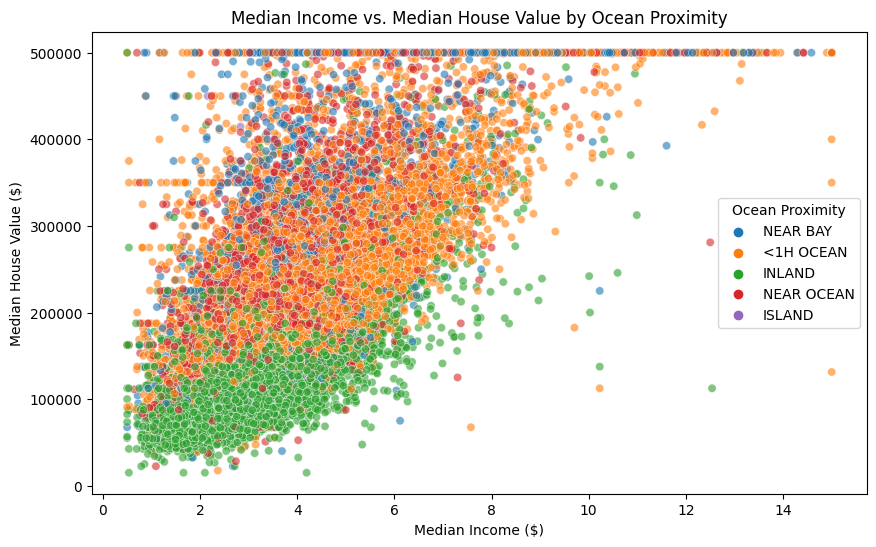

In [17]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='median_income', y='median_house_value', hue='ocean_proximity', alpha=0.6)
plt.title('Median Income vs. Median House Value by Ocean Proximity')
plt.xlabel('Median Income ($)')
plt.ylabel('Median House Value ($)')
plt.legend(title='Ocean Proximity')
plt.show()

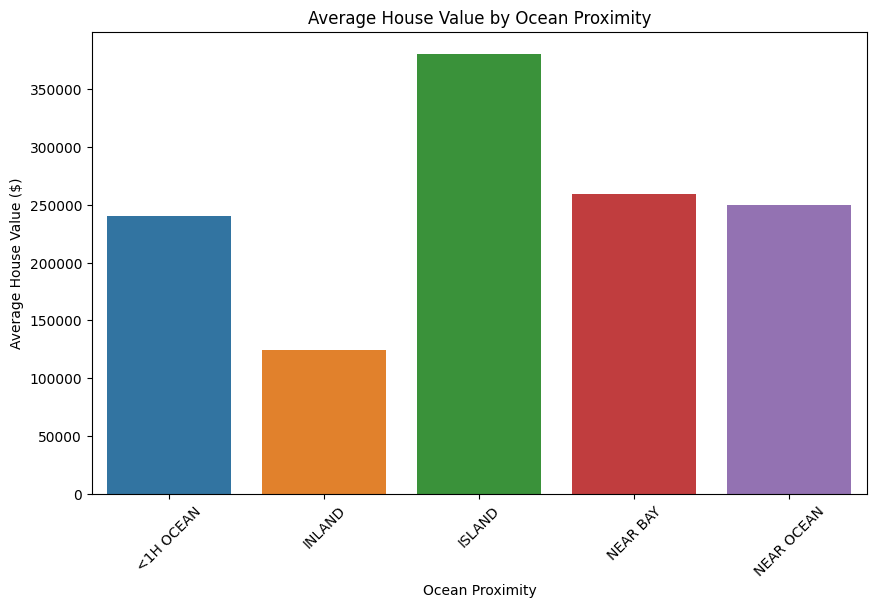

In [18]:
# Calculate average house value by ocean proximity
ocean_proximity_means = df.groupby("ocean_proximity")["median_house_value"].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=ocean_proximity_means, x='ocean_proximity', y='median_house_value')
plt.title('Average House Value by Ocean Proximity')
plt.xlabel('Ocean Proximity')
plt.ylabel('Average House Value ($)')
plt.xticks(rotation=45)
plt.show()

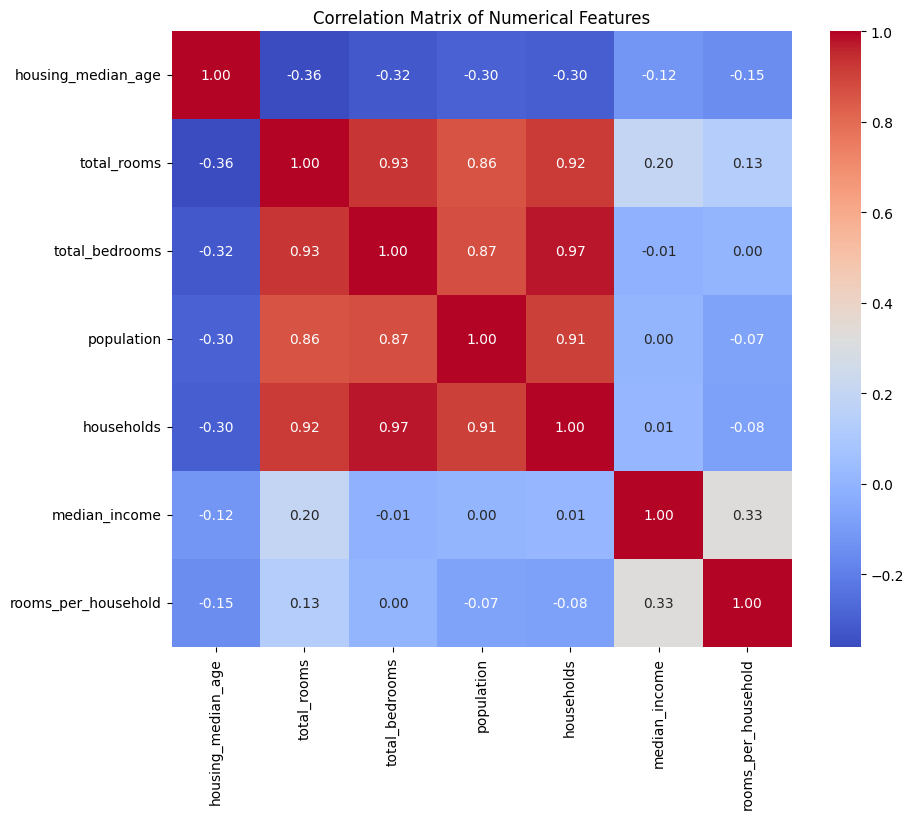

In [19]:
plt.figure(figsize=(10, 8))
corr_df = df[numerical_cols].apply(pd.to_numeric, errors='coerce').dropna()
corr_matrix = corr_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [20]:
# Encode categorical variable 'ocean_proximity'
df_encoded = pd.get_dummies(df, columns=['ocean_proximity'], drop_first=True)

In [21]:
# Define features (X) and target (y)
# Remove high-VIF features
X = df_encoded.drop(['median_house_value', 'longitude', 'latitude', 
                     'total_rooms', 'households'], axis=1)
y = df_encoded['median_house_value']

In [22]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# **Models**

In [24]:
# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

In [25]:
# Train and evaluate each model
results = []
for name, model in models.items():
    # Train the model
    model.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    results.append({
        'Model': name,
        'RMSE': rmse,
        'R2 Score': r2
    })
    
    if name == 'Linear Regression':
        feature_importance = pd.DataFrame({
            'Feature': X.columns,
            'Coefficient': model.coef_
        }).sort_values(by='Coefficient', ascending=False)
        print(f"\nFeature Importance for {name} (Coefficients):\n", feature_importance)
    else:
        feature_importance = pd.DataFrame({
            'Feature': X.columns,
            'Importance': model.feature_importances_
        }).sort_values(by='Importance', ascending=False)
        print(f"\nFeature Importance for {name} (Importance Scores):\n", feature_importance)


Feature Importance for Linear Regression (Coefficients):
                       Feature   Coefficient
3               median_income  74975.091730
1              total_bedrooms  46212.171791
0          housing_median_age  15701.054211
8  ocean_proximity_NEAR OCEAN   3969.208507
6      ocean_proximity_ISLAND   2341.661952
7    ocean_proximity_NEAR BAY   1027.427016
4         rooms_per_household  -1736.659178
5      ocean_proximity_INLAND -33570.391417
2                  population -39799.258902

Feature Importance for Random Forest (Importance Scores):
                       Feature  Importance
3               median_income    0.520304
5      ocean_proximity_INLAND    0.141176
1              total_bedrooms    0.089545
2                  population    0.086734
0          housing_median_age    0.080214
4         rooms_per_household    0.068694
8  ocean_proximity_NEAR OCEAN    0.007406
7    ocean_proximity_NEAR BAY    0.005320
6      ocean_proximity_ISLAND    0.000607

Feature Importance f

In [26]:
# Display model performance
results_df = pd.DataFrame(results)
print("\nModel Performance Comparison:\n", results_df)


Model Performance Comparison:
                Model          RMSE  R2 Score
0  Linear Regression  71795.404401  0.606643
1      Random Forest  63476.258659  0.692521
2  Gradient Boosting  64783.883944  0.679722


In [27]:
best_model_name = results_df.loc[results_df['R2 Score'].idxmax(), 'Model']
print(f"Best Model: {best_model_name}")
best_model = models[best_model_name]
y_pred = best_model.predict(X_test_scaled)

Best Model: Random Forest


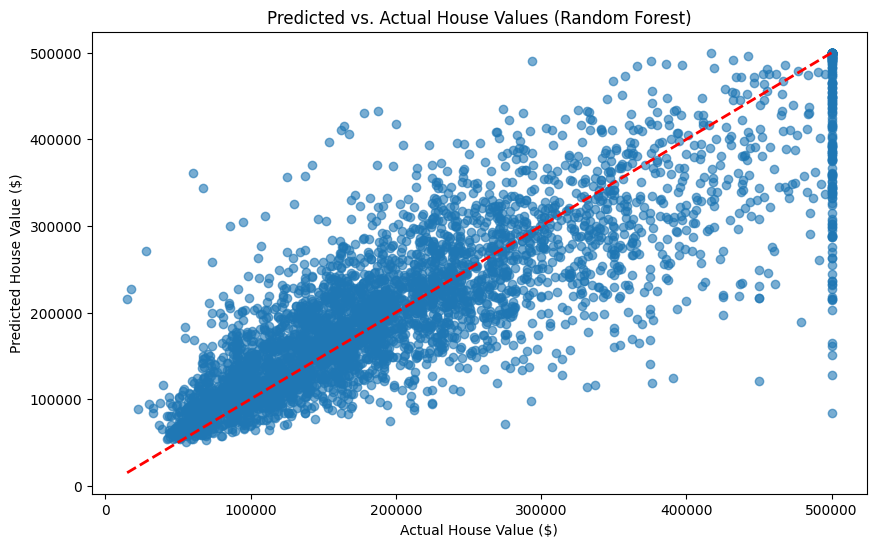

In [28]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title(f'Predicted vs. Actual House Values ({best_model_name})')
plt.xlabel('Actual House Value ($)')
plt.ylabel('Predicted House Value ($)')
plt.show()